# **Fast Food Classification using Transfer learning(Pytorch)**

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from collections import Counter

In [ ]:
# mounting google drive

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
os.chdir("../zipfile")

In [4]:
# unzip Facial_emotion_images.zip on the content folder using zipref
import zipfile

with zipfile.ZipFile('food_classification_dataset_V21.zip', 'r') as zip_ref:
    zip_ref.extractall('./../')

In [5]:
os.chdir("../../")

In [6]:
!ren "Food Classification Dataset V2" data

In [7]:
os.chdir("../data")

In [8]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is D40E-8AB6

 Directory of C:\Projects\StreamlitTest\data

09/18/2025  02:43 AM    <DIR>          .
09/18/2025  02:45 AM    <DIR>          ..
09/18/2025  02:43 AM    <DIR>          Test
09/18/2025  02:43 AM    <DIR>          Train
09/18/2025  02:43 AM    <DIR>          Valid
               0 File(s)              0 bytes
               5 Dir(s)   2,830,888,960 bytes free


##**Visualizing Our Classes**

In [6]:
import random
from PIL import Image
import time

def show_15_random_images_from_dir(base_data_dir,data_set_type,img_class_type):
    image_dir_path = os.path.join(base_data_dir,data_set_type, img_class_type)
    random.seed(time.time())  # New seed every time
    image_files = [f for f in os.listdir(image_dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(image_files)


    plt.figure(figsize=(15, 8))
    for i, file in enumerate(image_files[:15]):
        img_path = os.path.join(image_dir_path, file)
        img = Image.open(img_path).convert('L')
        plt.subplot(3, 5, i+1)  # 2 rows, 5 columns
        plt.imshow(img, cmap = "gray")
        plt.title(img_class_type)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

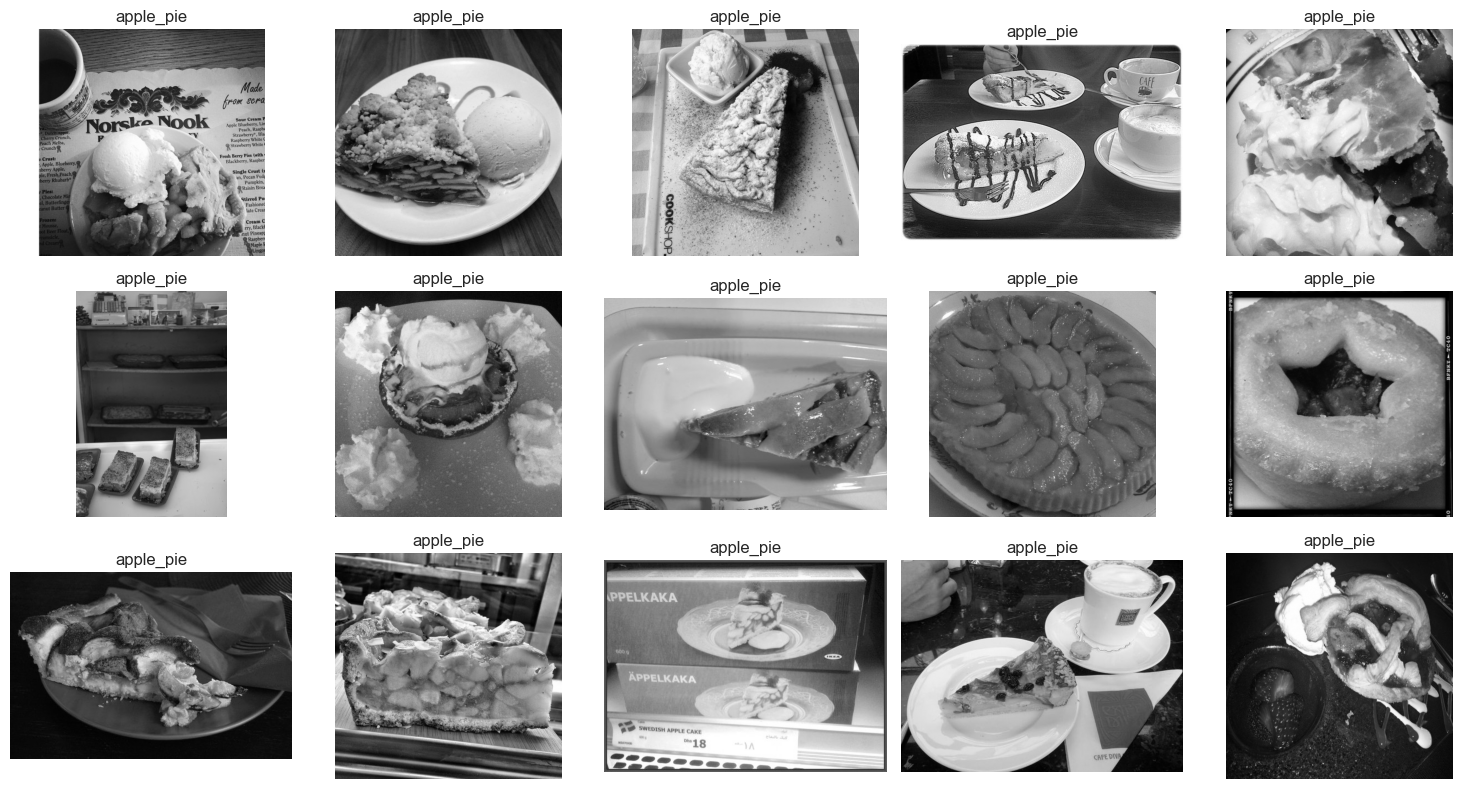

In [7]:
show_15_random_images_from_dir("../", "Train", "apple_pie")

## **Checking Distribution of Classes**

In [8]:
# Function to count images in each class directory
def count_images_per_class(data_dir):
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            # Count all image files (assuming common image extensions)
            image_files = [f for f in os.listdir(class_path)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            class_counts[class_name] = len(image_files)
    return class_counts

Train set class distribution:
  apple_pie: 595 images
  baked_potato: 1198 images
  burger: 1395 images
  butter_naan: 214 images
  chai: 243 images
  chapati: 254 images
  cheesecake: 594 images
  chicken_curry: 586 images
  chole_bhature: 261 images
  crispy_chicken: 1181 images
  dal_makhani: 205 images
  dhokla: 187 images
  donut: 1187 images
  fried_rice: 229 images
  fries: 1193 images
  hot_dog: 1107 images
  ice_cream: 592 images
  idli: 198 images
  jalebi: 193 images
  kaathi_rolls: 191 images
  kadai_paneer: 259 images
  kulfi: 158 images
  masala_dosa: 202 images
  momos: 205 images
  omelette: 587 images
  paani_puri: 95 images
  pakode: 179 images
  pav_bhaji: 214 images
  pizza: 1342 images
  samosa: 170 images
  sandwich: 1073 images
  sushi: 583 images
  taco: 987 images
  taquito: 1122 images
  Total: 18979 images

Validation set class distribution:
  apple_pie: 198 images
  baked_potato: 399 images
  burger: 465 images
  butter_naan: 71 images
  chai: 81 images
  ch

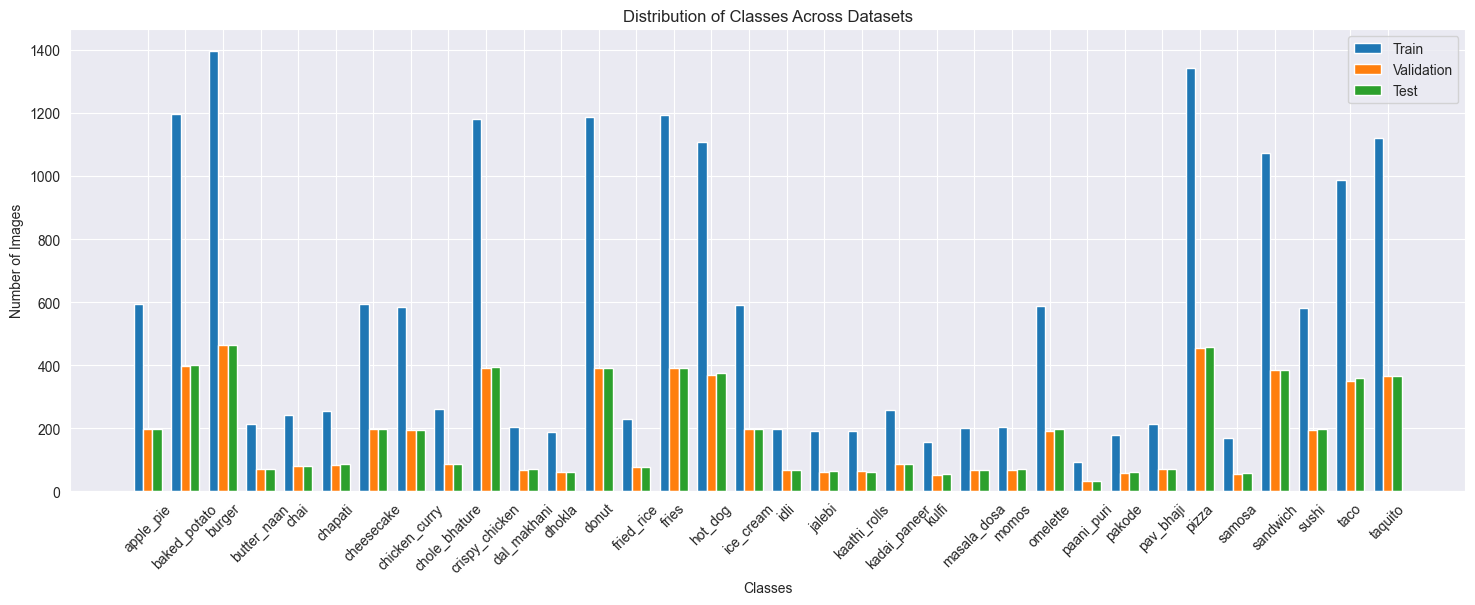

In [9]:
# Paths to each dataset split
base_data_dir = "../"
train_dir = os.path.join(base_data_dir, "Train")
val_dir = os.path.join(base_data_dir, "Valid")
test_dir = os.path.join(base_data_dir, "Test")

# Count images in each split
train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)
test_counts = count_images_per_class(test_dir)

# Print the counts
print("Train set class distribution:")
for class_name, count in train_counts.items():
    print(f"  {class_name}: {count} images")
print(f"  Total: {sum(train_counts.values())} images")

print("\nValidation set class distribution:")
for class_name, count in val_counts.items():
    print(f"  {class_name}: {count} images")
print(f"  Total: {sum(val_counts.values())} images")

print("\nTest set class distribution:")
for class_name, count in test_counts.items():
    print(f"  {class_name}: {count} images")
print(f"  Total: {sum(test_counts.values())} images")

# Visualize the distribution with a bar chart
plt.figure(figsize=(18, 6))

# Get all unique class names across all splits
all_classes = sorted(set(list(train_counts.keys()) + list(val_counts.keys()) + list(test_counts.keys())))

# Create x positions for the bars
x = np.arange(len(all_classes))
width = 0.25  # Width of the bars

# Create bars for each split
train_values = [train_counts.get(cls, 0) for cls in all_classes]
val_values = [val_counts.get(cls, 0) for cls in all_classes]
test_values = [test_counts.get(cls, 0) for cls in all_classes]

# Plot the bars
plt.bar(x - width, train_values, width, label='Train')
plt.bar(x, val_values, width, label='Validation')
plt.bar(x + width, test_values, width, label='Test')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes Across Datasets')
plt.xticks(x, all_classes, rotation = 45)
plt.legend()

# Adjust y-axis scale for better visibility (log scale)
#plt.yscale('log')

# Save the plot
plt.savefig('class_distribution.png')
plt.show()

### **Data Augmentation and Normalization**

In [10]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:
base_data_dir= "../"

In [12]:
image_datasets = {
    x: datasets.ImageFolder(os.path.join(base_data_dir, x),
                            data_transforms[x]) for x in ['Train', 'Valid']
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x],
                                   batch_size=32,
                                   shuffle=True,
                                ) for x in ['Train', 'Valid']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Valid']}

In [13]:
print(dataset_sizes)

{'Train': 18979, 'Valid': 6358}


In [14]:
class_names = image_datasets['Train'].classes

In [15]:
class_names

['apple_pie',
 'baked_potato',
 'burger',
 'butter_naan',
 'chai',
 'chapati',
 'cheesecake',
 'chicken_curry',
 'chole_bhature',
 'crispy_chicken',
 'dal_makhani',
 'dhokla',
 'donut',
 'fried_rice',
 'fries',
 'hot_dog',
 'ice_cream',
 'idli',
 'jalebi',
 'kaathi_rolls',
 'kadai_paneer',
 'kulfi',
 'masala_dosa',
 'momos',
 'omelette',
 'paani_puri',
 'pakode',
 'pav_bhaji',
 'pizza',
 'samosa',
 'sandwich',
 'sushi',
 'taco',
 'taquito']

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

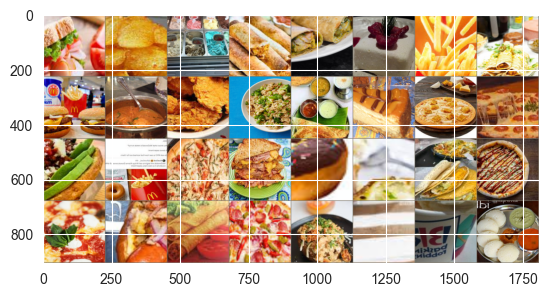

In [17]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Valid']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'Valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Valid Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
# model = models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model.fc = nn.Linear(num_ftrs, len(class_names))



# Option 1: EfficientNetV2-S (smallest variant)
# model = models.efficientnet_v2_s(pretrained=True)
# num_ftrs = model.classifier[1].in_features
# model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

# Option 2: EfficientNetV2-M (medium variant)
model = models.efficientnet_v2_m(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

# Option 3: EfficientNetV2-L (largest variant)
# model = models.efficientnet_v2_l(pretrained=True)
# num_ftrs = model.classifier[1].in_features
# model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_sgd = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer_adam = optim.Adam(model.parameters(), lr=0.0001)
optimizer_adam = optim.Adam(model.parameters(), lr=0.0001)  # Reduced from 0.001
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_adam, step_size=7, gamma=0.1)

F:\Projects\JupyterProject\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\Projects\JupyterProject\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to C:\Users\TIGER/.cache\torch\hub\checkpoints\efficientnet_v2_m-dc08266a.pth
100.0%


In [21]:
model = train_model(model, criterion, optimizer_adam, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


F:\Projects\JupyterProject\.venv\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.1184 Acc: 0.6952
Valid Loss: 0.3863 Acc: 0.8891

Epoch 1/9
----------
Train Loss: 0.5172 Acc: 0.8502
Valid Loss: 0.3246 Acc: 0.9108

Epoch 2/9
----------
Train Loss: 0.4081 Acc: 0.8800
Valid Loss: 0.4770 Acc: 0.9190

Epoch 3/9
----------
Train Loss: 0.3486 Acc: 0.8968
Valid Loss: 0.2712 Acc: 0.9259

Epoch 4/9
----------
Train Loss: 0.3006 Acc: 0.9118
Valid Loss: 0.2924 Acc: 0.9199

Epoch 5/9
----------
Train Loss: 0.2713 Acc: 0.9183
Valid Loss: 0.2761 Acc: 0.9281

Epoch 6/9
----------
Train Loss: 0.2558 Acc: 0.9252
Valid Loss: 0.2871 Acc: 0.9220

Epoch 7/9
----------
Train Loss: 0.2073 Acc: 0.9386
Valid Loss: 0.2473 Acc: 0.9330

Epoch 8/9
----------
Train Loss: 0.1752 Acc: 0.9479
Valid Loss: 0.2465 Acc: 0.9336

Epoch 9/9
----------
Train Loss: 0.1680 Acc: 0.9507
Valid Loss: 0.2424 Acc: 0.9355

Training complete in 58m 39s
Best Valid Acc: 0.935514


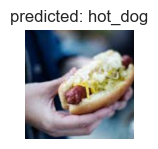

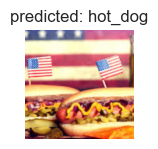

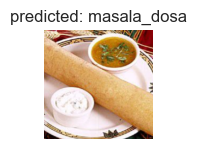

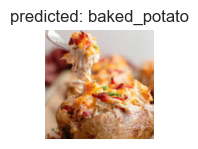

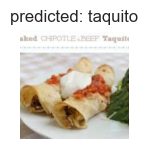

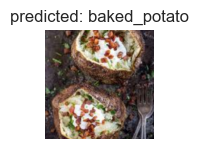

In [22]:
visualize_model(model)

## **Saving model**

In [ ]:
model_path = "../models/model_efficientnet_v2_m_1.pth"
torch.save(model.state_dict(), model_path)

In [ ]:
# test_transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

In [25]:
# test_data = datasets.ImageFolder(os.path.join(base_data_dir, "Test"), transform=test_transform)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [26]:
# test_dataiter = iter(test_dataloader)
# images, labels = next(test_dataiter)

In [27]:
class_names

['apple_pie',
 'baked_potato',
 'burger',
 'butter_naan',
 'chai',
 'chapati',
 'cheesecake',
 'chicken_curry',
 'chole_bhature',
 'crispy_chicken',
 'dal_makhani',
 'dhokla',
 'donut',
 'fried_rice',
 'fries',
 'hot_dog',
 'ice_cream',
 'idli',
 'jalebi',
 'kaathi_rolls',
 'kadai_paneer',
 'kulfi',
 'masala_dosa',
 'momos',
 'omelette',
 'paani_puri',
 'pakode',
 'pav_bhaji',
 'pizza',
 'samosa',
 'sandwich',
 'sushi',
 'taco',
 'taquito']

In [28]:
# # print images
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(8)))

## **Network performance**

In [29]:
# correct = 0
# total = 0
#
# with torch.no_grad():
#     for data in test_dataloader:
#         images, labels = data
#         images, labels = images.to(device), labels.to(device)
#
#         outputs = model(images)
#         _, pred = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (pred == labels)
# print(f'Accuracy of the network on test images: {100 * correct // total} %')

## **What are those classes that perform well?**

In [30]:
# prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}
#
# # again no gradients needed
# with torch.no_grad():
#     for data in test_dataloader:
#         images, labels = data
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         _, predictions = torch.max(outputs, 1)
#         # collect the correct predictions for each class
#         for label, prediction in zip(labels, predictions):
#             if label == prediction:
#                 correct_pred[classes[label]] += 1
#             total_pred[classes[label]] += 1
#
#
# # print accuracy for each class
# for classname, correct_count in correct_pred.items():
#     accuracy = 100 * float(correct_count) / total_pred[classname]
#     print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

## **Eval Single Image**

In [ ]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image

# Define the model architecture.
# We'll use the same ResNet-18 model from torchvision.
model = torchvision.models.efficientnet_v2_m(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

# Load the saved state_dict
model_path = "../models/model_efficientnet_v2_m_1.pth"
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()

In [ ]:
# Define the transformations for a single image.
# These should match the 'Valid' transformations from your training script.
image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the image you want to test
image_path = "./../pizza-1003.jpg"
image = Image.open(image_path)

# Apply the transformations to the image
image_tensor = image_transforms(image)

# Add a batch dimension to the tensor
# The model expects input in the shape of (batch_size, channels, height, width)
image_tensor = image_tensor.unsqueeze(0)

# Make a prediction
with torch.no_grad():
    output = model(image_tensor)

# Get the predicted class
_, predicted_class = torch.max(output, 1)

In [35]:
output

tensor([[-3.2830,  0.0798, -1.6518, -1.8952, -4.6039, -1.8284, -4.3846, -5.4446,
         -4.7572, -0.1686, -2.0919, -4.5951,  0.0803, -2.3797, -1.3283, -0.9159,
         -5.9605, -5.0119, -4.8779, -3.9008, -1.7047, -5.5402, -3.6108, -3.0515,
         -4.8301, -3.6284, -4.0406, -4.3185, 11.9717, -5.2442, -0.3276, -4.5428,
         -0.9692,  0.0293]])

In [36]:
predicted_class

tensor([28])

In [37]:
print(f"The predicted class is: {predicted_class.item()}")

The predicted class is: 28


In [38]:
class_names[predicted_class]

'pizza'